# Модель стоимости жилья в Магнитогорске

**id для демонстрации на собеседовании**
id = 3, 37, 82

## Введение

**Задача**

Построить математическую модель стоимости жилья в зависимости от параметров этого жилья.


Модель должна иметь REST API. На вход модели подаются параметры квартиры в формате JSON на выходе получается цена квартиры в формате JSON.

Испытание проводится в режиме демонстрации экрана на собеседовании. Модель тестируется на 3х квартирах на выбор кандидата. (Просьба подготовить исходные данные (запросы) заранее)


**Данные**


В качестве источника исходных данных предлагается использовать данные сайта магнитогорской недвижимости www.citystar.ru.

Размер выборки исходных данных не имеет значения, однако она должна быть представительной (не следует делать ее слишком большой, т.к. задача тестовая).

Данные должны быть загружены в базу данных.

## Импорт библиотек и загрузка данных

In [555]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
, 
RANDOM_STATE = 12345

In [556]:
# подключаемся к базе данных
cnx = sqlite3.connect('db/magnitogorsk.db')

In [557]:
# загружаем данные
data = pd.read_sql_query("SELECT * FROM offers", cnx)

In [558]:
# закрываем соединение с базой данных
cnx.close()

## Первичное знакомство с данными

In [559]:
def first_look(df, num_of_srtings=5):
    print('Общая информация')
    display(df.info())
    
    print(f'Первые {num_of_srtings} строк(и) данных')
    display(df.head(num_of_srtings))
    
    print('Основные статистические характеристики данных')
    display(df.describe())
    print('Количество пропусков:')
    print(df.isna().sum())
    print()
    
    print('Количество дубликатов:', df.duplicated().sum())

In [560]:
first_look(data)

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              456 non-null    int64  
 1   type            445 non-null    object 
 2   district        254 non-null    object 
 3   adress          456 non-null    object 
 4   floor           456 non-null    object 
 5   total_square    456 non-null    float64
 6   living_square   456 non-null    float64
 7   kitchen_square  456 non-null    float64
 8   price           456 non-null    int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 32.2+ KB


None

Первые 5 строк(и) данных


,id,type,district,adress,floor,total_square,living_square,kitchen_square,price
0,1,Трехкомнатная улучшенная,Орджоникидзевский,Ленина пр-т 145/2,1/5,64.0,43.0,8.0,3750
1,2,Трехкомнатная,Ленинский,Октябрьская 12,2/5,87.2,60.0,9.0,8300
2,3,Однокомнатная нестандартная,Орджоникидзевский,Ленина пр-т 135,6/14,36.1,20.0,9.0,3330
3,4,Трехкомнатная нестандартная,Орджоникидзевский,Ленина пр-т 129,5/16,105.0,75.0,14.0,7700
4,5,Двухкомнатная улучшенная,Орджоникидзевский,Сиреневый проезд 12,7/9,50.6,43.0,9.0,3800


Основные статистические характеристики данных


,id,total_square,living_square,kitchen_square,price
count,456.00000,456.000000,456.000000,456.000000,456.000000
mean,228.50000,53.514912,32.120175,8.771250,3744.561404
std,131.78012,21.751910,17.343334,4.007841,1631.107124
min,1.00000,14.100000,0.000000,0.000000,0.000000
25%,114.75000,40.175000,19.000000,6.000000,2700.000000
50%,228.50000,50.000000,30.000000,8.050000,3500.000000
75%,342.25000,65.000000,43.000000,10.000000,4600.000000
max,456.00000,220.000000,150.000000,30.000000,10000.000000


Количество пропусков:
id                  0
type               11
district          202
adress              0
floor               0
total_square        0
living_square       0
kitchen_square      0
price               0
dtype: int64

Количество дубликатов: 0


Посмотрим, есть ли в данных дубликаты, если мы не будем учитывать столбец id.

In [561]:
print('Количество дубликатов:', data.drop('id', axis=1).duplicated().sum())

Количество дубликатов: 2


In [562]:
data[data.drop('id', axis=1).duplicated()]

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price
354,355,Двухкомнатная раздельная,Орджоникидзевский (левый берег),Трамвайная 25,1/3,43.0,31.0,6.0,2350
413,414,Двухкомнатная,Правобережный,"Им. газеты ""Правда"" 23",4/5,46.1,29.0,6.0,2600


In [563]:
data_for_clean = data
data_for_clean

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price
0,1,Трехкомнатная улучшенная,Орджоникидзевский,Ленина пр-т 145/2,1/5,64.0,43.0,8.0,3750
1,2,Трехкомнатная,Ленинский,Октябрьская 12,2/5,87.2,60.0,9.0,8300
2,3,Однокомнатная нестандартная,Орджоникидзевский,Ленина пр-т 135,6/14,36.1,20.0,9.0,3330
3,4,Трехкомнатная нестандартная,Орджоникидзевский,Ленина пр-т 129,5/16,105.0,75.0,14.0,7700
4,5,Двухкомнатная улучшенная,Орджоникидзевский,Сиреневый проезд 12,7/9,50.6,43.0,9.0,3800
...,...,...,...,...,...,...,...,...,...
451,452,Однокомнатная,None,ул. Курортная 3,2/5,22.5,15.0,5.0,1580
452,453,Трехкомнатная,Правобережный,Западное шоссе 95,1/2,67.2,45.0,12.0,5000
453,454,Трехкомнатная нестандартная,Ленинский,Николая Шишка 22,5/5,74.0,56.0,9.0,5500
454,455,Двухкомнатная,None,Молодежная 19А,1/5,41.0,22.2,7.2,930


In [564]:
data.shape

(456, 9)

In [565]:
data.drop_duplicates(
    subset=['type', 'district', 'adress', 'floor', 'total_square', 'living_square', 'kitchen_square', 'price'],
    inplace=True
)

In [566]:
data.shape

(454, 9)

### Цена

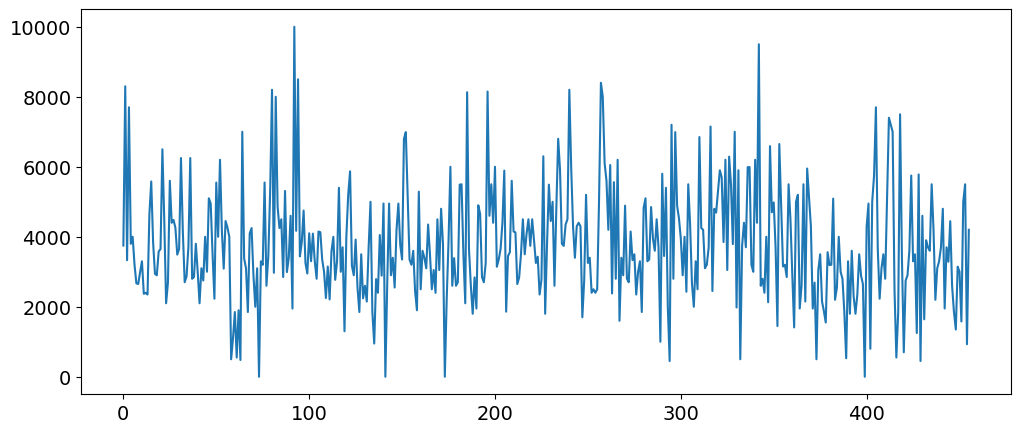

In [567]:
data['price'].plot(figsize=(12, 5));

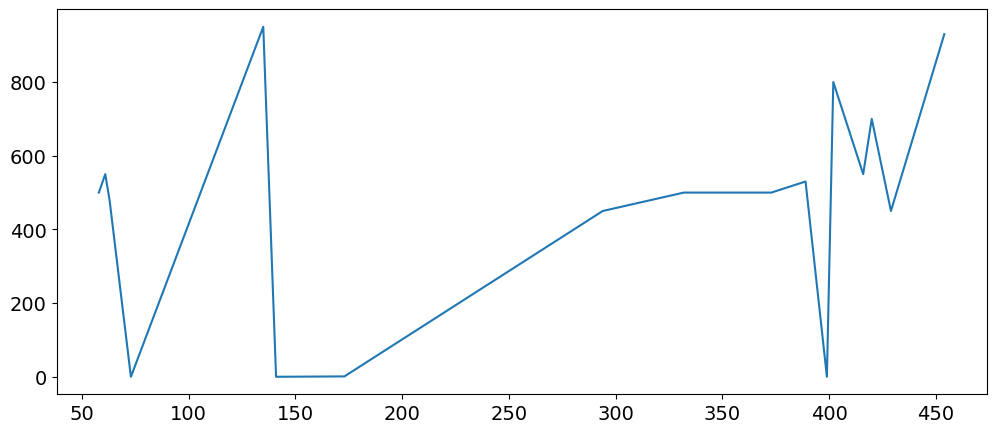

In [568]:
data[data['price'] < 1000]['price'].plot(figsize=(12, 5));

In [569]:
data[data['price'] < 800].shape[0] / data.shape[0] * 100

3.0837004405286343

In [570]:
data[data['price'] < 600]

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price
58,59,Трехкомнатная,None,Школьная 10,1/1,59.5,47.0,12.0,500
61,62,Двухкомнатная,None,Новая 1/5,1/2,47.0,29.0,8.0,550
63,64,Двухкомнатная,None,Новая 1/5,1/2,47.0,29.0,8.0,480
73,74,Однокомнатная,None,Первомайская 16,2/4,42.6,20.0,15.0,0
141,142,Однокомнатная,None,Труда 47,4/9,32.0,19.0,6.0,0
173,174,Однокомнатная малосемейка,Правобережный,Советской Армии 37/1,4/9,22.0,12.0,6.0,1
294,295,Однокомнатная,None,Привокзальная 29кв1,1/1,42.5,22.0,12.0,450
332,333,Двухкомнатная,None,Российская 7,2/2,45.0,31.0,6.0,500
373,374,Двухкомнатная,None,ул Черемушки 13,2/2,40.0,22.0,6.0,500
389,390,Трехкомнатная,None,Труда 2,1/2,63.4,0.0,0.0,530


Для трех квартир цена не указана, поэтому удалим эти строки, так как они не подходят ни для обучения модели ни для контроля качества. 

Количество квартир с нетипично низкой ценой составляет около 3 % данных. Удалим их, чтобы модель смогла точнее выявить закономерность.

In [571]:
# контроль размерности
data.shape

(454, 9)

In [572]:
data = data[data['price'] >= 800]

In [573]:
# контроль размерности
data.shape

(440, 9)

### Этаж

In [574]:
data['floor'].isna().sum()

0

In [575]:
def get_floor_num(row):
    return int(row[:row.find('/')])

In [576]:
data['floor_num'] = data['floor'].apply(get_floor_num)

C:\Users\Admin\AppData\Local\Temp\ipykernel_13216\2844724202.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['floor_num'] = data['floor'].apply(get_floor_num)


In [577]:
data['floor_num'].isna().sum()

0

In [578]:
def get_total_floors(row):
    return int(row[row.find('/')+1:])

In [579]:
data['total_floors'] = data['floor'].apply(get_total_floors)

C:\Users\Admin\AppData\Local\Temp\ipykernel_13216\3460811785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['total_floors'] = data['floor'].apply(get_total_floors)


In [580]:
data['total_floors'].isna().sum()

0

In [581]:
data.head()

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price,floor_num,total_floors
0,1,Трехкомнатная улучшенная,Орджоникидзевский,Ленина пр-т 145/2,1/5,64.0,43.0,8.0,3750,1,5
1,2,Трехкомнатная,Ленинский,Октябрьская 12,2/5,87.2,60.0,9.0,8300,2,5
2,3,Однокомнатная нестандартная,Орджоникидзевский,Ленина пр-т 135,6/14,36.1,20.0,9.0,3330,6,14
3,4,Трехкомнатная нестандартная,Орджоникидзевский,Ленина пр-т 129,5/16,105.0,75.0,14.0,7700,5,16
4,5,Двухкомнатная улучшенная,Орджоникидзевский,Сиреневый проезд 12,7/9,50.6,43.0,9.0,3800,7,9


Первоначально генерировала характеристики «первый этаж», «последний этаж». Но после анализа работы лучшей модели, выяснилось, что эти характеристики в рейтинге полезности заняли последние места, а модель, обученная без них, дает более высокие оценки.

Добавим столбец с информацией о том, является ли этаж квартиры первым.

In [582]:
data['is_first_floor'] = data['floor_num'] == 1
data['is_first_floor'] = data['is_first_floor'].astype('int')

C:\Users\Admin\AppData\Local\Temp\ipykernel_13216\741014905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_first_floor'] = data['floor_num'] == 1
C:\Users\Admin\AppData\Local\Temp\ipykernel_13216\741014905.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_first_floor'] = data['is_first_floor'].astype('int')


Добавим столбец с информацией о том, является ли этаж квартиры последним.

In [583]:
data['is_last_floor'] = data['floor_num'] == data['total_floors']
data['is_last_floor'] = data['is_last_floor'].astype('int')

C:\Users\Admin\AppData\Local\Temp\ipykernel_13216\4240899707.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_last_floor'] = data['floor_num'] == data['total_floors']
C:\Users\Admin\AppData\Local\Temp\ipykernel_13216\4240899707.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['is_last_floor'] = data['is_last_floor'].astype('int')


In [584]:
data.head(10)

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price,floor_num,total_floors,is_first_floor,is_last_floor
0,1,Трехкомнатная улучшенная,Орджоникидзевский,Ленина пр-т 145/2,1/5,64.0,43.0,8.0,3750,1,5,1,0
1,2,Трехкомнатная,Ленинский,Октябрьская 12,2/5,87.2,60.0,9.0,8300,2,5,0,0
2,3,Однокомнатная нестандартная,Орджоникидзевский,Ленина пр-т 135,6/14,36.1,20.0,9.0,3330,6,14,0,0
3,4,Трехкомнатная нестандартная,Орджоникидзевский,Ленина пр-т 129,5/16,105.0,75.0,14.0,7700,5,16,0,0
4,5,Двухкомнатная улучшенная,Орджоникидзевский,Сиреневый проезд 12,7/9,50.6,43.0,9.0,3800,7,9,0,0
5,6,Двухкомнатная улучшенная,Орджоникидзевский,Ленина пр-т 141,4/9,49.7,35.0,9.0,4000,4,9,0,0
6,7,Двухкомнатная,Правобережный,Советской Армии 9,1/5,43.8,28.6,6.0,3200,1,5,1,0
7,8,Однокомнатная брежневка,Правобережный,Карла Маркса 99,4/9,31.0,17.0,6.0,2670,4,9,0,0
8,9,Однокомнатная хрущевка,Ленинский,Ленинградская 37а,2/5,31.0,19.0,6.0,2650,2,5,0,0
9,10,Однокомнатная хабаровский вариант,Орджоникидзевский,Сиреневый проезд 14/2,6/6,37.0,19.0,8.0,2990,6,6,0,1


### Тип квартиры

В столбце с типом квартиры хранятся данные о количестве комнат и типе квартиры. Разделим их и сохраним в двух разных столбцах.

In [585]:
data['type'].isna().sum()

11

In [586]:
data['type'].isna().sum() / data.shape[0] * 100

2.5

In [587]:
data[data['type'].isna()]

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price,floor_num,total_floors,is_first_floor,is_last_floor
59,60,None,None,Ленина пр-т 212а,1/1,18.4,12.0,5.0,1100,1,1,1,1
83,84,None,None,Карла Маркса 233,8/10,70.0,50.0,7.0,4860,8,10,0,0
97,98,None,Орджоникидзевский,Завенягина 1,5/9,65.1,44.0,8.0,4750,5,9,0,0
140,141,None,None,Торфяная 5/2,1/2,46.8,0.0,0.0,4950,1,2,1,0
161,162,None,None,Карла Маркса 119/1,2/5,41.0,0.0,6.0,3600,2,5,0,0
162,163,None,None,Карла Маркса 117,2/5,41.0,26.0,6.0,3400,2,5,0,0
163,164,None,None,ул Жукова 17/1,4/9,40.1,18.0,9.0,3100,4,9,0,0
176,177,None,None,Западное шоссе 101,2/3,68.0,40.0,0.0,6000,2,3,0,0
355,356,None,None,ул Лесопарковая 93/1,10/10,41.2,28.0,12.5,3150,10,10,0,1
365,366,None,None,Ленина пр-т 114/4,5/14,40.0,18.0,13.0,2620,5,14,0,0


In [588]:
data = data[data['type'].notna()]

In [589]:
data['type'].unique()

array(['Трехкомнатная улучшенная', 'Трехкомнатная ',
       'Однокомнатная нестандартная', 'Трехкомнатная нестандартная',
       'Двухкомнатная улучшенная', 'Двухкомнатная ',
       'Однокомнатная брежневка', 'Однокомнатная хрущевка',
       'Однокомнатная хабаровский вариант', 'Однокомнатная ',
       'Трехкомнатная старой планировки', 'Двухкомнатная нестандартная',
       'Однокомнатная свердловский вариант', 'Двухкомнатная брежневка',
       'Трехкомнатная свердловский вариант',
       'Четырехкомнатная распашонка', 'Двухкомнатная гребенка',
       'Двухкомнатная раздельная', 'Двухкомнатная хрущевка',
       'Двухкомнатная старой планировки',
       'Однокомнатная сталинский вариант', 'Трехкомнатная брежневка',
       'Двухкомнатная сталинский вариант', 'Многокомнатная ',
       'Четырехкомнатная ', 'Однокомнатная улучшенная',
       'Двухкомнатная хабаровский вариант', 'Однокомнатная малосемейка',
       'Четырехкомнатная сталинский вариант', 'Трехкомнатная раздельная',
       'Тре

In [590]:
def get_num_of_rooms(row):
    return row[: row.find(' ')] if row.find(' ') > 0 else None

def get_flat_type(row):
    return 'неизвестно' if (len(row) - row.find(' ') == 1) or (row.find(' ') == -1) else row[row.find(' ')+1:]

In [591]:
get_num_of_rooms('Двухкомнатная свердловский вариант')

'Двухкомнатная'

In [592]:
print(get_flat_type('Двухкомнатная свердловский вариант'))

свердловский вариант


In [593]:
data['num_of_rooms'] = data['type'].apply(get_num_of_rooms)
data['flat_type'] = data['type'].apply(get_flat_type)

In [594]:
data.head()

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price,floor_num,total_floors,is_first_floor,is_last_floor,num_of_rooms,flat_type
0,1,Трехкомнатная улучшенная,Орджоникидзевский,Ленина пр-т 145/2,1/5,64.0,43.0,8.0,3750,1,5,1,0,Трехкомнатная,улучшенная
1,2,Трехкомнатная,Ленинский,Октябрьская 12,2/5,87.2,60.0,9.0,8300,2,5,0,0,Трехкомнатная,неизвестно
2,3,Однокомнатная нестандартная,Орджоникидзевский,Ленина пр-т 135,6/14,36.1,20.0,9.0,3330,6,14,0,0,Однокомнатная,нестандартная
3,4,Трехкомнатная нестандартная,Орджоникидзевский,Ленина пр-т 129,5/16,105.0,75.0,14.0,7700,5,16,0,0,Трехкомнатная,нестандартная
4,5,Двухкомнатная улучшенная,Орджоникидзевский,Сиреневый проезд 12,7/9,50.6,43.0,9.0,3800,7,9,0,0,Двухкомнатная,улучшенная


In [595]:
data['num_of_rooms'].isna().sum()

0

In [596]:
data['flat_type'].isna().sum()

0

In [597]:
data['num_of_rooms'].unique()

array(['Трехкомнатная', 'Однокомнатная', 'Двухкомнатная',
       'Четырехкомнатная', 'Многокомнатная'], dtype=object)

In [598]:
data['flat_type'].unique()

array(['улучшенная', 'неизвестно', 'нестандартная', 'брежневка',
       'хрущевка', 'хабаровский вариант', 'старой планировки',
       'свердловский вариант', 'распашонка', 'гребенка', 'раздельная',
       'сталинский вариант', 'малосемейка', 'смежная', 'евротрешка',
       'полусмежная', 'евродвушка', 'трапеция', 'ленинградский проект'],
      dtype=object)

### Улица

In [599]:
data[data['adress'] == ' '].shape

(4, 15)

In [600]:
data = data[data['adress'] != ' ']

In [601]:
sorted(data['adress'].unique())

['. Металлургов 18/1',
 '133/1 ',
 '14 ',
 '26 ул. Горнолыжная ',
 '50-летия Магнитки ',
 '50-летия Магнитки 32/2',
 '50-летия Магнитки 40/1',
 '50-летия Магнитки 50',
 '50-летия Магнитки 51а',
 '50-летия Магнитки 53',
 '50-летия Магнитки 59',
 '50-летия Магнитки 65/1',
 '50-летия Магнитки 70',
 '70 лет Октября 55',
 'Анджиевского 36А',
 'Болотникова 21',
 'Бориса Ручьева 3а',
 'Бориса Ручьева 7',
 'Бориса Ручьева 8/1',
 'Вознесенская 11',
 'Вокзальная 2',
 'Ворошилова 1',
 'Ворошилова 13/1',
 'Ворошилова 21',
 'Ворошилова 29',
 'Ворошилова 30',
 'Ворошилова 35',
 'Ворошилова 41',
 'Гагарина 18',
 'Галиуллина 27/2',
 'Галиуллина 47/2',
 'Галиуллина 5/1',
 'Герцена 2/1',
 'Герцена 31',
 'Герцена 33',
 'Горького 24',
 'Грязнова 14/1',
 'Грязнова 30',
 'Доменщиков 25',
 'Доменщиков 9/5',
 'Жукова 14/2',
 'Жукова 17/1',
 'Жукова 19/1',
 'Завенягина 6',
 'Западное шоссе 103',
 'Западное шоссе 107',
 'Западное шоссе 111',
 'Западное шоссе 444ак4',
 'Западное шоссе 95',
 'Зеленый Лог 17',
 'З

In [602]:
# sorted(data['adress'].unique())
data['adress'].nunique()

366

In [603]:
def get_street(row):
    dirt = ['ул. ', 'ул.', 'ул ', 'пр.']
    for dot in dirt:
        if dot in row:
            row = row.replace(dot, '')
    if row.find('. ') == 0:
        row = row[2:]
    return row[: row.rfind(' ')]

In [604]:
get_street('ул Сталеваров 18/1',)

'Сталеваров'

In [605]:
data['street'] = data['adress'].apply(get_street)

In [606]:
data['street'].isna().sum()

0

In [607]:
data.head()

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price,floor_num,total_floors,is_first_floor,is_last_floor,num_of_rooms,flat_type,street
0,1,Трехкомнатная улучшенная,Орджоникидзевский,Ленина пр-т 145/2,1/5,64.0,43.0,8.0,3750,1,5,1,0,Трехкомнатная,улучшенная,Ленина пр-т
1,2,Трехкомнатная,Ленинский,Октябрьская 12,2/5,87.2,60.0,9.0,8300,2,5,0,0,Трехкомнатная,неизвестно,Октябрьская
2,3,Однокомнатная нестандартная,Орджоникидзевский,Ленина пр-т 135,6/14,36.1,20.0,9.0,3330,6,14,0,0,Однокомнатная,нестандартная,Ленина пр-т
3,4,Трехкомнатная нестандартная,Орджоникидзевский,Ленина пр-т 129,5/16,105.0,75.0,14.0,7700,5,16,0,0,Трехкомнатная,нестандартная,Ленина пр-т
4,5,Двухкомнатная улучшенная,Орджоникидзевский,Сиреневый проезд 12,7/9,50.6,43.0,9.0,3800,7,9,0,0,Двухкомнатная,улучшенная,Сиреневый проезд


In [608]:
data['street'].nunique()

91

In [609]:
def get_street(row):
    dirt = ['ул. ', 'ул.', 'ул ', 'пр.']
    for dot in dirt:
        if dot in row:
            row = row.replace(dot, '')
    if row.find('. ') == 0:
        row = row[2:]
    return row

In [610]:
data['street'] = data['street'].apply(get_street)

In [611]:
streets_to_replace = {
    'зеленый лог' : 'Зеленый Лог',
    'Зеленый лог' : 'Зеленый Лог',
    'Зеленый лог 30 к' : 'Зеленый Лог',
    'Им. газеты \\"Правда\\"' : 'имени газеты Правда',
    'Им. газеты "Правда"' : 'имени газеты Правда',
    'проспект Сиреневый' : 'Сиреневый проезд',
    'карла маркса' : 'Карла Маркса',
    '50 лет Магнитки' : '50-летия Магнитки',
    'Ленина пр-т 210' : 'Ленина пр-т',
    'Советский переулок 12' : 'Советский переулок',
    '26 Горнолыжная' : 'Горнолыжная'
}

In [612]:
data['street'].replace(streets_to_replace, inplace=True)

In [613]:
data.shape

(425, 16)

In [614]:
sorted(data['street'].unique())

['133/1',
 '14',
 '50-летия Магнитки',
 '70 лет Октября',
 'Анджиевского',
 'Болотникова',
 'Бориса Ручьева',
 'Вознесенская',
 'Вокзальная',
 'Ворошилова',
 'Габдрауфа Давлетова',
 'Гагарина',
 'Галиуллина',
 'Герцена',
 'Горнолыжная',
 'Горького',
 'Грязнова',
 'Доменщиков',
 'Жукова',
 'Завенягина',
 'Западное шоссе',
 'Зеленый Лог',
 'Индустриальная',
 'Казакова',
 'Калинина',
 'Калмыкова',
 'Карла Маркса',
 'Коробова',
 'Красноармейская',
 'Кронштадтская',
 'Куйбышева',
 'Курортная',
 'Ленина пр-т',
 'Ленинградская',
 'Лесная',
 'Лесопарковая',
 'Менделеева',
 'Металлургов',
 'Мичурина',
 'Молодежная',
 'Московская',
 'Набережная',
 'Николая Шишка',
 'Октябрьская',
 'Оранжерейная',
 'Панькова',
 'Парковая',
 'Первомайская',
 'Пионерская',
 'Подольская',
 'Помяловского',
 'Пушкина',
 'Раздольная',
 'Ржевского переулок',
 'Садовая',
 'Салтыкова-Щедрина',
 'Сиреневый проезд',
 'Советская',
 'Советский переулок',
 'Советской Армии',
 'Солнечный Берег',
 'Сочинская',
 'Сталеваров',
 'С

In [615]:
data['street'].nunique()

82

### Район

Посмотрим количество пропусков в столбце с данными о районе.

In [616]:
data['district'].isna().sum()

176

Заполним пропуски значением 'неизвестно'.

In [617]:
data['district'].fillna('неизвестно', inplace=True)

In [618]:
data['district'].isna().sum()

0

In [619]:
data['district'].unique()

array(['Орджоникидзевский', 'Ленинский', 'Правобережный', 'неизвестно',
       'Орджоникидзевский (левый берег)', 'ленинский',
       'Орджоникидзевский район', 'Орджо', 'правобережный'], dtype=object)

In [620]:
data['district'].nunique()

9

In [621]:
districts_to_replace = {
    'ленинский' : 'Ленинский',
    'Орджоникидзевский район' : 'Орджоникидзевский',
    'Орджо' : 'Орджоникидзевский',
    'правобережный' : 'Правобережный'
}

In [622]:
data['district'].replace(districts_to_replace, inplace=True)

In [623]:
data['district'].nunique()

5

In [624]:
data['district'].unique()

array(['Орджоникидзевский', 'Ленинский', 'Правобережный', 'неизвестно',
       'Орджоникидзевский (левый берег)'], dtype=object)

## Построение модели

### Подготовка обучающей и валидационной выборки.

Выделим характеристики, которые будем использовать для обучения модели.

|столбец|комментарий|
|:--|:--|
|id|не влияет на цену квартиры|
|type|вместо него будем использовать более информативные столбцы, сгенерированные на основе данных из этого столбца|
|**district**|может оказывать влияние|
|adress|вместо него будем использовать более информативные столбцы, сгенерированные на основе данных из этого столбца|
|floor|вместо него будем использовать более информативные столбцы, сгенерированные на основе данных из этого столбца|
|**total_square**|может оказывать влияние|
|**living_square**|может оказывать влияние|
|**kitchen_square**|может оказывать влияние|
|**price**|целевой признак|
|**floor_num**|может оказывать влияние|
|**total_floors**|может оказывать влияние|
|**is_first_floor**|может оказывать влияние|
|**is_last_floor**|может оказывать влияние|
|**num_of_rooms**|может оказывать влияние|
|**flat_type**|может оказывать влияние|
|**street**|может оказывать влияние|

In [625]:
features = data.drop(['id', 'type', 'adress', 'floor', 'price'], axis=1)

In [626]:
features.head()

,district,total_square,living_square,kitchen_square,floor_num,total_floors,is_first_floor,is_last_floor,num_of_rooms,flat_type,street
0,Орджоникидзевский,64.0,43.0,8.0,1,5,1,0,Трехкомнатная,улучшенная,Ленина пр-т
1,Ленинский,87.2,60.0,9.0,2,5,0,0,Трехкомнатная,неизвестно,Октябрьская
2,Орджоникидзевский,36.1,20.0,9.0,6,14,0,0,Однокомнатная,нестандартная,Ленина пр-т
3,Орджоникидзевский,105.0,75.0,14.0,5,16,0,0,Трехкомнатная,нестандартная,Ленина пр-т
4,Орджоникидзевский,50.6,43.0,9.0,7,9,0,0,Двухкомнатная,улучшенная,Сиреневый проезд


In [627]:
target = data['price']

In [628]:
target.head()

0    3750
1    8300
2    3330
3    7700
4    3800
Name: price, dtype: int64

In [629]:
features.isna().sum()

district          0
total_square      0
living_square     0
kitchen_square    0
floor_num         0
total_floors      0
is_first_floor    0
is_last_floor     0
num_of_rooms      0
flat_type         0
street            0
dtype: int64

Разобьем выборки на обучающую и валидационную в отношении 4 : 1.

In [630]:
features_train, features_val, target_train, target_val = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=RANDOM_STATE
)

In [631]:
features_train.isna().sum()

district          0
total_square      0
living_square     0
kitchen_square    0
floor_num         0
total_floors      0
is_first_floor    0
is_last_floor     0
num_of_rooms      0
flat_type         0
street            0
dtype: int64

### Предварительна обработка данных

Трансформер для предварительной обработки данных

In [632]:
data_for_clean.head()

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price
0,1,Трехкомнатная улучшенная,Орджоникидзевский,Ленина пр-т 145/2,1/5,64.0,43.0,8.0,3750
1,2,Трехкомнатная,Ленинский,Октябрьская 12,2/5,87.2,60.0,9.0,8300
2,3,Однокомнатная нестандартная,Орджоникидзевский,Ленина пр-т 135,6/14,36.1,20.0,9.0,3330
3,4,Трехкомнатная нестандартная,Орджоникидзевский,Ленина пр-т 129,5/16,105.0,75.0,14.0,7700
4,5,Двухкомнатная улучшенная,Орджоникидзевский,Сиреневый проезд 12,7/9,50.6,43.0,9.0,3800


In [633]:
data_for_clean = data_for_clean[data_for_clean['type'].notna()]

In [634]:
class DataCleaner(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.districts_to_replace = {
            'ленинский' : 'Ленинский',
            'Орджоникидзевский район' : 'Орджоникидзевский',
            'Орджо' : 'Орджоникидзевский',
            'правобережный' : 'Правобережный'
        }
        self.streets_to_replace = {
            'зеленый лог' : 'Зеленый Лог',
            'Зеленый лог' : 'Зеленый Лог',
            'Зеленый лог 30 к' : 'Зеленый Лог',
            'Им. газеты \\"Правда\\"' : 'имени газеты Правда',
            'Им. газеты "Правда"' : 'имени газеты Правда',
            'проспект Сиреневый' : 'Сиреневый проезд',
            'карла маркса' : 'Карла Маркса',
            '50 лет Магнитки' : '50-летия Магнитки',
            'Ленина пр-т 210' : 'Ленина пр-т',
            'Советский переулок 12' : 'Советский переулок',
            '26 Горнолыжная' : 'Горнолыжная'
        }
        
    def __get_street(self, row):
        dirt = ['ул. ', 'ул.', 'ул ', 'пр.']
        for dot in dirt:
            if dot in row:
                row = row.replace(dot, '')
        if row.find('. ') == 0:
            row = row[2:]
        return row[: row.rfind(' ')]
    
    def fit(self, X):
        return self

    def transform(self, X):
         
        # обработка дубликатов и пропусков района
        X['district'].replace(self.districts_to_replace, inplace=True)
        X['district'].fillna('неизвестно', inplace=True)
        
        # обработка дубликатов улиц
        X['adress'] = X['adress'].apply(self.__get_street)
        X['adress'].replace(self.streets_to_replace, inplace=True)
                        
        return X

In [635]:
dc = DataCleaner()
data_for_clean_res = dc.fit_transform(data_for_clean)

C:\Users\Admin\AppData\Local\Temp\ipykernel_13216\3611594148.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['district'].replace(self.districts_to_replace, inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_13216\3611594148.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['district'].fillna('неизвестно', inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_13216\3611594148.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [636]:
data_for_clean_res.head()

,id,type,district,adress,floor,total_square,living_square,kitchen_square,price
0,1,Трехкомнатная улучшенная,Орджоникидзевский,Ленина пр-т,1/5,64.0,43.0,8.0,3750
1,2,Трехкомнатная,Ленинский,Октябрьская,2/5,87.2,60.0,9.0,8300
2,3,Однокомнатная нестандартная,Орджоникидзевский,Ленина пр-т,6/14,36.1,20.0,9.0,3330
3,4,Трехкомнатная нестандартная,Орджоникидзевский,Ленина пр-т,5/16,105.0,75.0,14.0,7700
4,5,Двухкомнатная улучшенная,Орджоникидзевский,Сиреневый проезд,7/9,50.6,43.0,9.0,3800


In [646]:
features.columns

Index(['district', 'total_square', 'living_square', 'kitchen_square',
       'floor_num', 'total_floors', 'is_first_floor', 'is_last_floor',
       'num_of_rooms', 'flat_type', 'street'],
      dtype='object')

In [652]:
class FeaturesTransformer(BaseEstimator, TransformerMixin):
    columns_ = [
        'district', 
        'adress', 
        'total_square', 
        'living_square', 
        'kitchen_square', 
        'floor_num', 
        'total_floors', 
        'num_of_rooms', 
        'flat_type'
    ]
    def __init__(self):
        pass
        
    def __get_floor_num(self, row):
        return int(row[:row.find('/')])
    
    def __get_total_floors(self, row):
        return int(row[row.find('/')+1:])

    def __get_num_of_rooms(self, row):
        return row[: row.find(' ')] if row.find(' ') > 0 else None

    def __get_flat_type(self, row):
        return 'неизвестно' if (len(row) - row.find(' ') == 1) or (row.find(' ') == -1) else row[row.find(' ')+1:]
    
    def fit(self, X):
        return self

    def transform(self, X):
         
        # номер этажа квартиры
        floor_num = X['floor'].apply(self.__get_floor_num)

        # общее количество этажей в доме
        total_floors = X['floor'].apply(self.__get_total_floors)

        num_of_rooms = X['type'].apply(self.__get_num_of_rooms)
        flat_type = X['type'].apply(self.__get_flat_type)
        
        X = np.c_[X.drop(['id', 'floor', 'type'], axis=1), floor_num, total_floors, num_of_rooms, flat_type]               
        return X

In [653]:
fm = FeaturesTransformer()

In [654]:
data_for_clean_res_fm = fm.fit_transform(data_for_clean_res)

In [655]:
data_for_clean_res_fm = pd.DataFrame(data_for_clean_res_fm)
data_for_clean_res_fm.head()

,0,1,2,3,4,5,6,7,8,9
0,Орджоникидзевский,Ленина пр-т,64.0,43.0,8.0,3750,1,5,Трехкомнатная,улучшенная
1,Ленинский,Октябрьская,87.2,60.0,9.0,8300,2,5,Трехкомнатная,неизвестно
2,Орджоникидзевский,Ленина пр-т,36.1,20.0,9.0,3330,6,14,Однокомнатная,нестандартная
3,Орджоникидзевский,Ленина пр-т,105.0,75.0,14.0,7700,5,16,Трехкомнатная,нестандартная
4,Орджоникидзевский,Сиреневый проезд,50.6,43.0,9.0,3800,7,9,Двухкомнатная,улучшенная


In [651]:
fm.columns

['district',
 'adress',
 'total_square',
 'living_square',
 'kitchen_square',
 'floor_num',
 'total_floors',
 'num_of_rooms',
 'flat_type']

Выделим категориальные и числовые признаки.

In [309]:
numeric = ['total_square', 'living_square', 'kitchen_square',
       'floor_num', 'total_floors', 'is_first_floor', 'is_last_floor']
categorical = ['district', 'num_of_rooms', 'flat_type', 'street']

Количество комнат попадает в категориальные признаки, потому что содержит значение «многоквартирная», которое нельзя заменить конкретным числовым значением.

Преобразуем категориальные признаки в числа с помощью порядкового кодирования. 

In [310]:
features_train.head()

,district,total_square,living_square,kitchen_square,floor_num,total_floors,is_first_floor,is_last_floor,num_of_rooms,flat_type,street
206,неизвестно,22.0,12.0,5.0,6,9,0,0,Однокомнатная,неизвестно,Бориса Ручьева
199,неизвестно,48.0,9.0,25.0,4,9,0,0,Однокомнатная,неизвестно,Карла Маркса
305,Орджоникидзевский,58.0,42.0,7.0,5,9,0,0,Трехкомнатная,брежневка,Ворошилова
93,Ленинский,67.2,35.9,11.0,2,2,0,1,Двухкомнатная,старой планировки,Герцена
273,неизвестно,65.0,0.0,9.0,2,9,0,0,Трехкомнатная,неизвестно,Сиреневый проезд


In [311]:
col_transformer = ColumnTransformer(
   transformers=[
       ('oe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1), categorical)
       # ('scaler', StandardScaler(), features_train.columns)
       ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

    

In [312]:
X_train = pd.DataFrame(col_transformer.fit_transform(features_train))

In [313]:
col_transformer.feature_names_in_

array(['district', 'total_square', 'living_square', 'kitchen_square',
       'floor_num', 'total_floors', 'is_first_floor', 'is_last_floor',
       'num_of_rooms', 'flat_type', 'street'], dtype=object)

In [314]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10
0,4.0,2.0,5.0,4.0,22.0,12.0,5.0,6.0,9.0,0.0,0.0
1,4.0,2.0,5.0,22.0,48.0,9.0,25.0,4.0,9.0,0.0,0.0
2,1.0,3.0,0.0,7.0,58.0,42.0,7.0,5.0,9.0,0.0,0.0
3,0.0,0.0,13.0,11.0,67.2,35.9,11.0,2.0,2.0,0.0,1.0
4,4.0,3.0,5.0,50.0,65.0,0.0,9.0,2.0,9.0,0.0,0.0


In [315]:
my_pipeline = Pipeline([
    ('col_transformer', ColumnTransformer(
   transformers=[
       ('oe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1), categorical)
       ],
    remainder="passthrough",
    verbose_feature_names_out=False
)),
    ('scaler', StandardScaler())
])

In [316]:
x_piped = pd.DataFrame(my_pipeline.fit_transform(features_train))

In [317]:
x_piped.columns = categorical + numeric
x_piped

,district,num_of_rooms,flat_type,street,total_square,living_square,kitchen_square,floor_num,total_floors,is_first_floor,is_last_floor
0,1.025638,0.277145,-0.360087,-1.587622,-1.431076,-1.115889,-0.963241,0.839670,0.813310,-0.522885,-0.636364
1,1.025638,0.277145,-0.360087,-0.667000,-0.232604,-1.286261,3.935852,0.075312,0.813310,-0.522885,-0.636364
2,-0.809714,1.037059,-1.790338,-1.434185,0.228347,0.587835,-0.473332,0.457491,0.813310,-0.522885,-0.636364
3,-1.421498,-1.242682,1.928315,-1.229602,0.652422,0.241411,0.506487,-0.689046,-1.279314,-0.522885,1.571429
4,1.025638,1.037059,-0.360087,0.765079,0.551012,-1.797378,0.016578,-0.689046,0.813310,-0.522885,-0.636364
...,...,...,...,...,...,...,...,...,...,...,...
335,0.413854,-1.242682,-1.790338,0.918516,-0.416984,-0.150445,-0.473332,0.457491,-0.382475,-0.522885,1.571429
336,1.025638,0.277145,-0.360087,-0.411271,-0.831840,-0.661562,-1.208196,0.075312,-0.382475,-0.522885,-0.636364
337,1.025638,0.277145,-0.360087,-0.411271,-1.408028,-0.945516,-0.963241,-0.689046,-0.382475,-0.522885,-0.636364
338,-1.421498,0.277145,1.642265,0.202477,-0.924030,-0.661562,-0.473332,-0.306867,-0.382475,-0.522885,-0.636364


In [318]:
features_train_sc

,district,num_of_rooms,flat_type,street,total_square,living_square,kitchen_square,floor_num,total_floors,is_first_floor,is_last_floor
0,-0.768132,0.252053,-0.047680,-0.360772,-0.639131,-0.707860,0.032162,2.360121,1.100421,-0.517357,1.645151
1,-0.768132,1.006002,2.361058,1.592775,0.497479,0.584627,0.032162,0.838038,0.803316,-0.517357,-0.607847
2,-0.768132,0.252053,-0.649865,-1.562956,-1.389202,-1.045031,-1.002495,-0.684044,0.803316,-0.517357,-0.607847
3,1.043299,-1.255844,-0.348773,-1.813411,2.108060,1.820918,4.170792,-1.825606,-1.573524,-0.517357,-0.607847
4,-0.768132,1.006002,-1.252049,-0.911773,1.325777,1.090382,2.877470,-1.064565,1.100421,1.932902,-0.607847
...,...,...,...,...,...,...,...,...,...,...,...
336,0.318727,-1.255844,-0.348773,-0.661318,-0.376837,-0.145909,-0.743831,0.076997,-0.385104,-0.517357,-0.607847
337,-0.768132,0.252053,-0.348773,-0.661318,-0.054721,-0.145909,1.325484,3.501683,2.883052,-0.517357,-0.607847
338,0.318727,0.252053,-0.348773,-0.360772,-1.297169,-1.045031,-0.485166,0.457517,2.883052,-0.517357,-0.607847
339,-1.492704,0.252053,1.758873,0.140137,-0.975053,-0.707860,-0.485166,-0.303524,-0.385104,-0.517357,-0.607847


In [319]:
X_test = pd.DataFrame(my_pipeline.transform(features_val))
X_test.columns = categorical + numeric
X_test

,district,num_of_rooms,flat_type,street,total_square,living_square,kitchen_square,floor_num,total_floors,is_first_floor,is_last_floor
0,1.025638,0.277145,-0.360087,-1.025019,-0.601364,-0.661562,0.016578,-0.306867,0.813310,-0.522885,-0.636364
1,-0.809714,-1.242682,-0.360087,-0.360126,0.444994,0.814998,-0.105900,1.221849,1.112256,-0.522885,-0.636364
2,1.025638,1.037059,-0.360087,-0.411271,1.703389,1.610069,-0.473332,-0.689046,-1.279314,-0.522885,1.571429
3,-1.421498,1.037059,-0.074037,0.151331,0.965868,1.382906,0.016578,0.457491,-0.382475,-0.522885,1.571429
4,0.413854,-1.242682,-0.360087,0.509351,-0.440032,-0.264027,-0.718286,0.075312,-0.382475,-0.522885,-0.636364
...,...,...,...,...,...,...,...,...,...,...,...
80,-1.421498,-1.242682,1.928315,0.100185,0.320537,0.019927,0.016578,-1.071225,-0.681422,1.912468,-0.636364
81,1.025638,-1.242682,-0.360087,0.816225,-0.163461,0.019927,-0.105900,0.075312,0.813310,-0.522885,-0.636364
82,-0.809714,1.037059,-1.790338,-1.792204,0.689298,0.758207,-0.718286,0.457491,-0.382475,-0.522885,1.571429
83,-0.809714,0.277145,-0.074037,-0.360126,-0.587536,-0.661562,0.016578,2.368386,1.112256,-0.522885,1.571429


In [320]:
features_val_sc

,district,num_of_rooms,flat_type,street,total_square,living_square,kitchen_square,floor_num,total_floors,is_first_floor,is_last_floor
0,-0.768132,-1.255844,-0.047680,0.791320,0.087931,0.135066,0.032162,1.218559,0.803316,-0.517357,-0.607847
1,-0.768132,1.006002,-0.348773,0.540865,0.589512,0.697017,-0.226502,-0.684044,-0.385104,-0.517357,-0.607847
2,1.043299,-1.255844,-0.348773,0.791320,-0.054721,0.416041,0.032162,1.979600,0.803316,-0.517357,1.645151
3,1.043299,1.759951,-0.348773,0.841411,0.313412,0.697017,-0.485166,0.076997,-0.385104,-0.517357,-0.607847
4,-1.492704,0.252053,-0.348773,0.240319,-1.297169,-1.101226,-0.485166,-1.064565,-0.979314,1.932902,-0.607847
...,...,...,...,...,...,...,...,...,...,...,...
81,1.043299,0.252053,-0.348773,0.941593,-1.067086,-0.820250,-0.743831,0.457517,0.803316,-0.517357,-0.607847
82,0.318727,-1.255844,0.554504,0.841411,-0.468870,-0.145909,-0.743831,-1.064565,-0.385104,1.932902,-0.607847
83,1.043299,0.252053,-0.348773,1.592775,-0.988858,-0.764055,-0.743831,0.838038,0.803316,-0.517357,-0.607847
84,0.318727,1.006002,-2.155326,1.091866,0.497479,0.809407,-0.743831,-0.684044,-0.385104,-0.517357,-0.607847


In [321]:
features_train['district'].isna().sum()

0

In [322]:
oe = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value = -1
)

In [323]:
cat_features_train = pd.DataFrame(oe.fit_transform(features_train[categorical]))
cat_features_train.columns = categorical

In [324]:
cat_features_train

,district,num_of_rooms,flat_type,street
0,4.0,2.0,5.0,4.0
1,4.0,2.0,5.0,22.0
2,1.0,3.0,0.0,7.0
3,0.0,0.0,13.0,11.0
4,4.0,3.0,5.0,50.0
...,...,...,...,...
335,3.0,0.0,0.0,53.0
336,4.0,2.0,5.0,27.0
337,4.0,2.0,5.0,27.0
338,0.0,2.0,12.0,39.0


In [325]:
features_train_oe =pd.merge(
    cat_features_train, 
    features_train[numeric].reset_index(drop=True), 
    left_index=True, 
    right_index=True)
features_train_oe

,district,num_of_rooms,flat_type,street,total_square,living_square,kitchen_square,floor_num,total_floors,is_first_floor,is_last_floor
0,4.0,2.0,5.0,4.0,22.0,12.0,5.0,6,9,0,0
1,4.0,2.0,5.0,22.0,48.0,9.0,25.0,4,9,0,0
2,1.0,3.0,0.0,7.0,58.0,42.0,7.0,5,9,0,0
3,0.0,0.0,13.0,11.0,67.2,35.9,11.0,2,2,0,1
4,4.0,3.0,5.0,50.0,65.0,0.0,9.0,2,9,0,0
...,...,...,...,...,...,...,...,...,...,...,...
335,3.0,0.0,0.0,53.0,44.0,29.0,7.0,5,5,0,1
336,4.0,2.0,5.0,27.0,35.0,20.0,4.0,4,5,0,0
337,4.0,2.0,5.0,27.0,22.5,15.0,5.0,2,5,0,0
338,0.0,2.0,12.0,39.0,33.0,20.0,7.0,3,5,0,0


In [326]:
target_train = target_train.reset_index(drop=True)

In [327]:
cat_features_val = pd.DataFrame(oe.transform(features_val[categorical]))
cat_features_val.columns = categorical

In [328]:
features_val_oe =pd.merge(
    cat_features_val, 
    features_val[numeric].reset_index(drop=True), 
    left_index=True, 
    right_index=True)
features_val_oe

,district,num_of_rooms,flat_type,street,total_square,living_square,kitchen_square,floor_num,total_floors,is_first_floor,is_last_floor
0,4.0,2.0,5.0,15.0,40.0,20.0,9.0,3,9,0,0
1,1.0,0.0,5.0,28.0,62.7,46.0,8.5,7,10,0,0
2,4.0,3.0,5.0,27.0,90.0,60.0,7.0,2,2,0,1
3,0.0,3.0,6.0,38.0,74.0,56.0,9.0,5,5,0,1
4,3.0,0.0,5.0,45.0,43.5,27.0,6.0,4,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...
80,0.0,0.0,13.0,37.0,60.0,32.0,9.0,1,4,1,0
81,4.0,0.0,5.0,51.0,49.5,32.0,8.5,4,9,0,0
82,1.0,3.0,0.0,0.0,68.0,45.0,6.0,5,5,0,1
83,1.0,2.0,6.0,28.0,40.3,20.0,9.0,10,10,0,1


In [329]:
target_val = target_val.reset_index(drop=True)

In [330]:
target_val

0     3050
1     5950
2     7400
3     5500
4     2650
      ... 
80    3840
81    3400
82    4130
83    3300
84    6200
Name: price, Length: 85, dtype: int64

Теперь масштабируем наши данные.

In [331]:
sscaler = StandardScaler()

In [332]:
features_train_sc = pd.DataFrame(sscaler.fit_transform(features_train_oe))
features_train_sc.columns = features_train_oe.columns

In [333]:
features_train_sc.head()

,district,num_of_rooms,flat_type,street,total_square,living_square,kitchen_square,floor_num,total_floors,is_first_floor,is_last_floor
0,1.025638,0.277145,-0.360087,-1.587622,-1.431076,-1.115889,-0.963241,0.839670,0.813310,-0.522885,-0.636364
1,1.025638,0.277145,-0.360087,-0.667000,-0.232604,-1.286261,3.935852,0.075312,0.813310,-0.522885,-0.636364
2,-0.809714,1.037059,-1.790338,-1.434185,0.228347,0.587835,-0.473332,0.457491,0.813310,-0.522885,-0.636364
3,-1.421498,-1.242682,1.928315,-1.229602,0.652422,0.241411,0.506487,-0.689046,-1.279314,-0.522885,1.571429
4,1.025638,1.037059,-0.360087,0.765079,0.551012,-1.797378,0.016578,-0.689046,0.813310,-0.522885,-0.636364


In [334]:
features_val_sc = pd.DataFrame(sscaler.transform(features_val_oe))
features_val_sc.columns = features_val_oe.columns

In [335]:
features_val_sc.head()

,district,num_of_rooms,flat_type,street,total_square,living_square,kitchen_square,floor_num,total_floors,is_first_floor,is_last_floor
0,1.025638,0.277145,-0.360087,-1.025019,-0.601364,-0.661562,0.016578,-0.306867,0.813310,-0.522885,-0.636364
1,-0.809714,-1.242682,-0.360087,-0.360126,0.444994,0.814998,-0.105900,1.221849,1.112256,-0.522885,-0.636364
2,1.025638,1.037059,-0.360087,-0.411271,1.703389,1.610069,-0.473332,-0.689046,-1.279314,-0.522885,1.571429
3,-1.421498,1.037059,-0.074037,0.151331,0.965868,1.382906,0.016578,0.457491,-0.382475,-0.522885,1.571429
4,0.413854,-1.242682,-0.360087,0.509351,-0.440032,-0.264027,-0.718286,0.075312,-0.382475,-0.522885,-0.636364


Модель линейной регрессии

In [336]:
class MyLinearRegression:
    
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = np.linalg.inv(X.T @ X) @ X.T @ y
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

In [337]:
# наша модель
model_1 = MyLinearRegression()
model_1.fit(features_train_sc, target_train)
predictions = model_1.predict(features_val_sc)

# метрика MAE
mae = mean_absolute_error(target_val, predictions)
print(mae)

670.4431317386436


In [338]:
target_val

0     3050
1     5950
2     7400
3     5500
4     2650
      ... 
80    3840
81    3400
82    4130
83    3300
84    6200
Name: price, Length: 85, dtype: int64

In [339]:
for i in range(10):
    print(target_val.iloc[i], predictions.iloc[i])

3050 3325.599614883922
5950 4540.729468173786
7400 5543.679510336424
5500 5093.216786174191
2650 3123.9359849302377
3000 3391.5973534048057
4200 4564.73533999639
2800 2676.8183715761843
4300 4801.299901445298
2750 4714.254416011844


In [340]:
from sklearn.tree import DecisionTreeRegressor

In [341]:
DTR = DecisionTreeRegressor(
    max_depth=10,
    random_state=RANDOM_STATE
)

In [342]:
DTR.fit(features_train_sc, target_train)

DecisionTreeRegressor(max_depth=10, random_state=12345)

In [343]:
predictionsDTR = DTR.predict(features_val_sc)

# метрика MAE
maeDTR = mean_absolute_error(target_val, predictionsDTR)
print(maeDTR)

584.4095798319328


In [344]:
from sklearn.ensemble import RandomForestRegressor

In [345]:
# список гиперпараметров и их значений
search_space = {
    'criterion' : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'max_depth' : [5, 10, 15],
    'n_estimators' : [50, 100, 200],
    'max_features' : ['sqrt', 'log2', 1]
}

In [346]:
model_rfr = RandomForestRegressor(
    random_state=RANDOM_STATE
)

In [347]:
GS = GridSearchCV(
    estimator=model_rfr,
    param_grid=search_space,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=4
)

In [348]:
# GS.fit(features_train_sc, target_train)

In [349]:
# GS.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [350]:
# GS.best_estimator_

In [351]:
RFR = RandomForestRegressor(
    # criterion='poisson',
    max_depth=10, 
    # max_features='sqrt',
    n_estimators=100,
    random_state=RANDOM_STATE
)

In [352]:
# RFR = RandomForestRegressor(
#     max_depth=10,
#     random_state=RANDOM_STATE,
#     n_estimators=100
# )

In [353]:
features_val_oe = features_val_oe.reset_index(drop=True)
features_val_oe = features_val_oe.reset_index(drop=True)


In [354]:
features_train_oe

,district,num_of_rooms,flat_type,street,total_square,living_square,kitchen_square,floor_num,total_floors,is_first_floor,is_last_floor
0,4.0,2.0,5.0,4.0,22.0,12.0,5.0,6,9,0,0
1,4.0,2.0,5.0,22.0,48.0,9.0,25.0,4,9,0,0
2,1.0,3.0,0.0,7.0,58.0,42.0,7.0,5,9,0,0
3,0.0,0.0,13.0,11.0,67.2,35.9,11.0,2,2,0,1
4,4.0,3.0,5.0,50.0,65.0,0.0,9.0,2,9,0,0
...,...,...,...,...,...,...,...,...,...,...,...
335,3.0,0.0,0.0,53.0,44.0,29.0,7.0,5,5,0,1
336,4.0,2.0,5.0,27.0,35.0,20.0,4.0,4,5,0,0
337,4.0,2.0,5.0,27.0,22.5,15.0,5.0,2,5,0,0
338,0.0,2.0,12.0,39.0,33.0,20.0,7.0,3,5,0,0


In [355]:
RFR.fit(features_train_oe, target_train)

RandomForestRegressor(max_depth=10, random_state=12345)

In [356]:
predictionsRFR = RFR.predict(features_val_oe)

# метрика MAE
maeRFR = mean_absolute_error(target_val, predictionsRFR)
print(maeRFR)

484.40183170790715


In [357]:
mean_absolute_percentage_error(target_val, predictionsRFR)*100

14.394678346650213

In [358]:
mean_squared_error(target_val, predictionsRFR) ** 0.5

710.4819721171884

In [359]:
for i in range(10):
    print(target_val.iloc[i], predictionsRFR[i])

3050 3077.3578144028265
5950 5031.168593073593
7400 5981.3
5500 5628.870070923227
2650 3110.8790654891704
3000 2619.872596453667
4200 4223.886001082251
2800 2457.8251015628457
4300 4668.214626557652
2750 4545.348458646617


In [360]:
len(target_val)

85

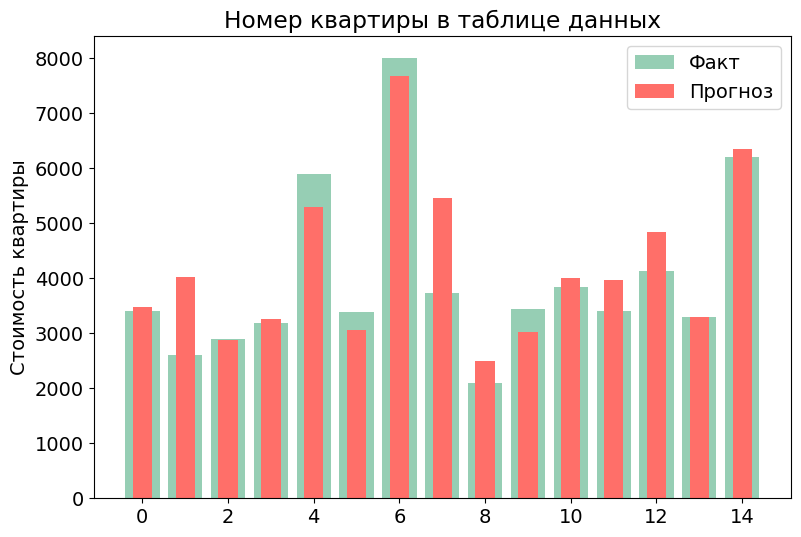

In [362]:
# построим диаграмму значений
fig, ax = plt.subplots(figsize=(9, 6))
plt.rc('font', size=14)
x = [i for i in range(15)]

ax.bar(x, target_val[70:], color='#96ceb4', label='Факт')
ax.bar(x, predictionsRFR[70:], width = .45, color='#ff6f69', label='Прогноз')
# ax.plot(x, [y_test[:13].median() for i in range(13)], color='#36454f', label='Медиана')



ax.set_ylabel('Стоимость квартиры')
ax.set_title('Номер квартиры в таблице данных')
ax.legend()
plt.show()

In [381]:
sorted(zip(RFR.feature_importances_, features_val_oe.columns), reverse=True)

[(0.7861470773282115, 'total_square'),
 (0.048892837872232205, 'kitchen_square'),
 (0.035272117090729076, 'total_floors'),
 (0.03270213068882061, 'living_square'),
 (0.02834756357789161, 'street'),
 (0.023247244037990923, 'num_of_rooms'),
 (0.017489784124856828, 'floor_num'),
 (0.01169198236821737, 'district'),
 (0.009954800374147735, 'flat_type'),
 (0.0031727346518088386, 'is_last_floor'),
 (0.00308172788509332, 'is_first_floor')]

In [364]:
most_important = [
    'total_square', 
    'total_floors', 
    'kitchen_square', 
    'living_square', 
    'street', 
    'num_of_rooms', 
    'floor_num',
    'district',
    'flat_type'
]

In [365]:
RFR_mi = RandomForestRegressor(
    # criterion='poisson',
    max_depth=10, 
    # max_features='sqrt',
    n_estimators=100,
    random_state=RANDOM_STATE
)

In [366]:
RFR_mi.fit(features_train_sc[most_important], target_train)

RandomForestRegressor(max_depth=10, random_state=12345)

In [368]:
predictionsRFR_mi = RFR_mi.predict(features_val_sc[most_important])

# метрика MAE
maeRFR_mi = mean_absolute_error(target_val, predictionsRFR_mi)
print(maeRFR_mi)

481.9743672950661


In [ ]:
features_val_oe.iloc[10].to_json('test_features.json')

In [ ]:
# test = pd.read_json('test.json', typ='series')

In [ ]:
test_1 =  pd.read_json('test_features.json', typ='series')
test_1

In [ ]:
RFR.predict([test_1])

In [ ]:
RFR.predict([pd.read_json('test_features.json', typ='series')])[0]

In [ ]:
target_val.iloc[10]

In [ ]:
 3, 37, 82

In [ ]:
example_1 = data[data['id'] == 3]

In [ ]:
example_1['price']

In [ ]:
model_1.predict(sscaler.transform())